In [246]:
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adadelta
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from skimage.io import imread
from keras.callbacks import EarlyStopping
from six.moves import xrange

## 1. Read images

In [247]:
TRAIN_IMG_PATH = 'banco_dados_SB/train/imagens/'
TRAIN_LBL_PATH = 'banco_dados_SB/train/classes/'

TEST_IMG_PATH = 'banco_dados_SB/test/imagens/'
TEST_LBL_PATH = 'banco_dados_SB/test/classes/'

In [248]:
X_train = [imread(fname=TRAIN_IMG_PATH + img, as_grey=True) for img in os.listdir(TRAIN_IMG_PATH)]
y_train = [imread(fname=TRAIN_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TRAIN_LBL_PATH)]

### Criando um validation set

In [249]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)

In [250]:
X_test = [imread(fname=TEST_IMG_PATH + img, as_grey=True) for img in os.listdir(TEST_IMG_PATH)]
y_test = [imread(fname=TEST_LBL_PATH + lbl)[:, :, 0] for lbl in os.listdir(TEST_LBL_PATH)]

In [251]:
X_test = np.asarray(X_test)/255
y_test = np.asarray(y_test)

In [252]:
X_train.shape
len(X_train)

338

In [253]:
bounds = int(len(X_train)-(np.floor(338*.1)))
print (bounds)
X_validate = X_train[bounds:,:,:]
y_validate = y_train[bounds:,:,:]
X_train = X_train[:bounds,:,:]
y_train = y_train[:bounds,:,:]
X_train = X_train[:10,:,:]
y_train = y_train[:10,:,:]
print(X_validate.shape,y_validate.shape )
print(X_train.shape,y_train.shape )

305
(33, 256, 256) (33, 256, 256)
(10, 256, 256) (10, 256, 256)


### Testing data set

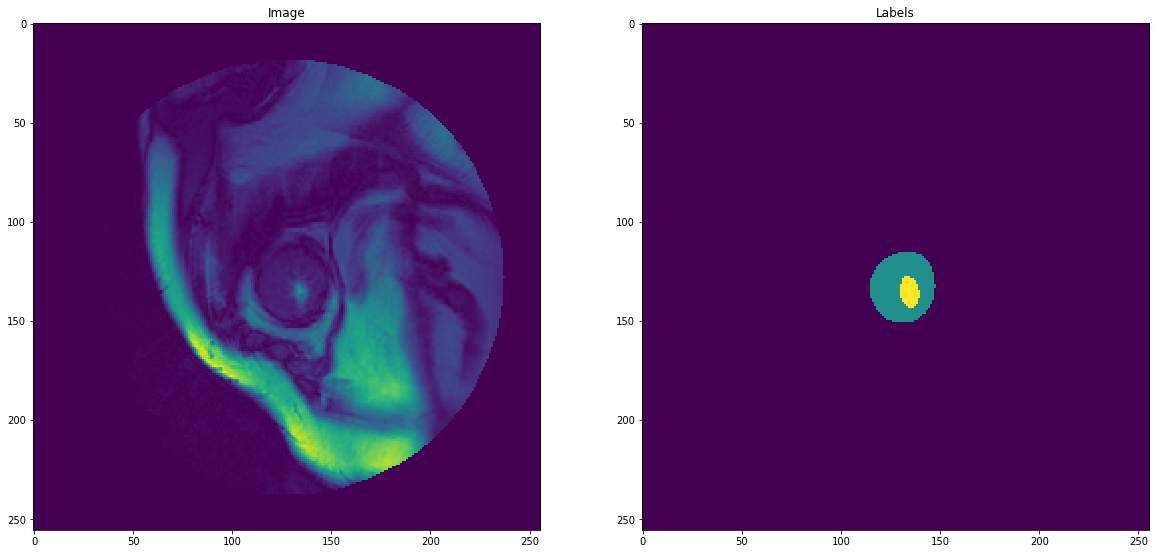

In [254]:
idx = 3

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[idx])
ax[0].set_title('Image')

ax[1].imshow(y_train[idx])
ax[1].set_title('Labels')

plt.show()

### função inicializador bilinear

In [255]:
def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)

def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    upsample_kernel = upsample_filt(filter_size)
    for i in xrange(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

In [256]:
def bilinear_init(filter_size,num_channels):
    #Create bilinear weights in numpy array
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel
        return weights

In [257]:
W_bilinear = bilinear_init (8,1)
W_bilinear = np.asarray(W_bilinear,dtype = 'float32')
W_bilinear = np.reshape(W_bilinear,[8,8])

## 2. Create CNN model

In [258]:
input_shape = (X_train[0].shape[0], X_train[0].shape[1], 1)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer= 'glorot_normal',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (7, 7), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(512, (7, 7), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(3, (7, 7), activation='relu',kernel_initializer= 'glorot_normal', padding='same'))
#kernel_initializer=keras.initializers.Constant(value=W_bilinear)
model.add(Conv2DTranspose(3, kernel_size=(8,8), strides=(8, 8), padding='valid', data_format=None, activation=None, 
                use_bias=True,bias_initializer='zeros'))
model.add(Activation(activation='softmax'))

In [259]:
print (input_shape, X_train.shape)
model.summary()

(256, 256, 1) (10, 256, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 64, 64, 256

In [260]:
model.compile(loss='binary_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

## 3. Prepare data

In [261]:
# Reshape input images to fit TensorFlow shape pattern
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validate = X_validate.reshape(X_validate.shape[0], X_validate.shape[1], X_validate.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [262]:
# One hot encoded label images
y_train_ohe = np.zeros((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))
y_validate_ohe = np.zeros((y_validate.shape[0], y_validate.shape[1], y_validate.shape[2], 3))
y_test_ohe = np.zeros((y_test.shape[0], y_test.shape[1], y_test.shape[2], 3))

In [263]:
y_train_ohe[:, :, :, 0] = np.where(y_train == 0, 1, 0)
y_train_ohe[:, :, :, 1] = np.where(y_train == 1, 1, 0)
y_train_ohe[:, :, :, 2] = np.where(y_train == 2, 1, 0)

In [264]:
y_validate_ohe[:, :, :, 0] = np.where(y_validate == 0, 1, 0)
y_validate_ohe[:, :, :, 1] = np.where(y_validate == 1, 1, 0)
y_validate_ohe[:, :, :, 2] = np.where(y_validate == 2, 1, 0)

In [265]:
y_test_ohe[:, :, :, 0] = np.where(y_test == 0, 1, 0)
y_test_ohe[:, :, :, 1] = np.where(y_test == 1, 1, 0)
y_test_ohe[:, :, :, 2] = np.where(y_test == 2, 1, 0)

## 4. Train model

In [266]:
from keras.models import load_model
savings = "./savings"
if os.path.isdir(savings):
    path_sav = 'savings/'
    model = load_model(path_sav +'Lis_net.h5')

In [267]:
batch_size = 2
epochs = 1
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True,batch_size=batch_size)

# Monitorando se a função não esta aprendendo mais...
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(X_train, y_train_ohe,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_validate, y_validate_ohe),
          callbacks=[tbCallBack,early_stopping])

Train on 10 samples, validate on 33 samples
Epoch 1/1
10/10 [==============================] - 56s - loss: 0.6341 - acc: 0.6666 - val_loss: 0.6331 - val_acc: 0.6666


In [268]:
if not os.path.isdir(savings):
    path_sav = 'savings/'
    os.makedirs(path_sav)
model.save(path_sav +'Lis_net.h5')

In [269]:
P_fig = model.predict(X_test, batch_size=batch_size, verbose=1)

82/82 [==============================] - 66s    


In [270]:
ch0_arr = np.asarray (P_fig[:,:,:,0])
ch1_arr = np.asarray (P_fig[:,:,:,1])
ch2_arr = np.asarray (P_fig[:,:,:,2])
ch_shape = ch0_arr.shape
print(ch_shape)

(82, 256, 256)


In [271]:
ch0_arr = np.reshape(ch0_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])
ch1_arr = np.reshape(ch1_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])
ch2_arr = np.reshape(ch2_arr,[ch_shape[0]*ch_shape[1]*ch_shape[2]])

In [272]:
im_final = np.zeros(ch0_arr.shape)
for ii in np.arange(len(ch0_arr)):
    if ch0_arr[ii]>ch1_arr[ii] and ch0_arr[ii]>ch2_arr[ii]:
        im_final[ii] = 0
    elif ch1_arr[ii]>ch0_arr[ii] and ch1_arr[ii]>ch2_arr[ii]:
        im_final[ii] = 1
    else:
        im_final[ii] = 2
im_final = np.reshape(im_final,ch_shape)

Text(0.5,1,'Imagem final')

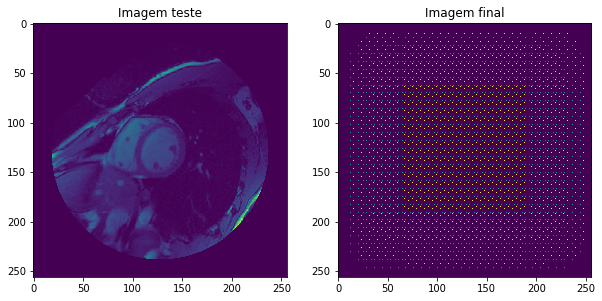

In [273]:
idx = 9

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X_test[idx,:,:,0])
ax[0].set_title('Imagem teste')

ax[1].imshow(im_final[idx,:,:])
ax[1].set_title('Imagem final')

In [274]:
sess = tf.Session()
writer = tf.summary.FileWriter("Graph")
writer.add_graph (sess.graph)
sess.close()